In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from IPython.display import display, HTML
from collections import namedtuple

figdir = "./plots/figs/"
Path(figdir).mkdir(parents=True, exist_ok=True)

In [265]:
COL_SIZE = 6
ROW_SIZE = 4

sorted_ops = ['native_sort',
            'native_index_select',
            'native_addmm',
            'native_gather',
            'native_index_add_',
            'scatter_add',
            'scatter_mean',
            'scatter_min',
            'scatter_max',
            'scatter_multiply',
            'sparse_spmm',
            'sparse_spspmm',
            'sparse_transpose']


def get_markers_colors():
    markers = itertools.cycle(['o', 's', '^', 'x', 'v', '+', 'D', '8', '*', 'p', '<', '>', 'd', 'H'])
    colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
    return markers, colors


def reload_data():
    p = Path("./data/").glob('*.csv')

    op2df = {x.name.split('.')[0]:
             pd.read_csv(x, index_col=0)
                 for x in p if x.is_file()}

    all_ops = list(op2df.keys())
    
    assert set(all_ops) == set(sorted_ops), "New ops in ./data"
    return op2df, sorted_ops


def _split_column(df, i=None, col=None, delim_colname=", ", delim_values=" "):
    cols = df.columns.to_list()
    if col is None:
        assert i is not None, "`i` and `col` cannot both be None"
        col = cols[i]
    df[col.split(delim_colname)] = df[col].str.split(delim_values, expand=True)#.astype(float, errors='ignore')
    df = df.drop(columns=col)
    return df.convert_dtypes()


def split_time_col(df):
    df = df.rename(columns={"GPU clock time": "GPU clock time|GPU clock time PT"})
    df = _split_column(df, i=None, col="GPU clock time|GPU clock time PT", delim_colname="|", delim_values=" ")
    df["GPU clock time PT"] = df["GPU clock time PT"].str.replace("(\(|\))", "", regex=True)
    return df.astype({"GPU clock time": float, "GPU clock time PT": float})


def split_column(df, i=None, col=None, delim_colname=", ", delim_values=" "):
    df = _split_column(df, i=i, col=col, delim_colname=delim_colname, delim_values=delim_values)
    if not pd.api.types.is_numeric_dtype(df["GPU clock time"]):
        df = split_time_col(df)
    return df


def plot_operation(df, 
                   plots_cols, 
                   curves_cols, 
                   x_col="Sparsity", 
                   y_col='GPU clock time', 
                   op_name=None, 
                   swap_rows_cols=False, 
                   show_title=True,
                   **kwargs):
    """
    x_col = "Sparsity"
    y_col = ['GPU clock time']
    plots_cols = ['shape']
    curves_cols = ["Reduce factor"]
    """
    df = df.rename(columns={"Input size (>95% mem util)*": "Input size"})
    if plots_cols is not None:
        plots_cols = ["Input size" if c == "Input size (>95% mem util)*" else c for c in plots_cols]
    if curves_cols is not None:
        curves_cols = ["Input size" if c == "Input size (>95% mem util)*" else c for c in curves_cols]
    
    try:
        df = df.set_index(x_col)
    except KeyError:
        pass

    if isinstance(y_col, str):
        y_col = [c for c in df.columns if y_col in c]
    
    if plots_cols is None:
        GrObj = namedtuple('GrObj', 'ngroups groups get_group')
        grouped = GrObj(ngroups=1, groups={" ": ""}, get_group=(lambda x: df))
    else:
        grouped = df.groupby(plots_cols)

    if grouped.ngroups <= 4:
        ncols = grouped.ngroups
        nrows = 1
    else:
        ncols = 4
        nrows = int(np.ceil(grouped.ngroups/ncols))
        
    if swap_rows_cols:
        tmp = ncols
        ncols = nrows
        nrows = tmp
    
    if "axes" not in kwargs.keys():
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(COL_SIZE * ncols, ROW_SIZE * nrows)) #, sharey=True
        if show_title:
            fig.suptitle(op_name, fontsize=16)
    else:
        axes = kwargs["axes"]

    try:
        axes = axes.flatten()
    except AttributeError:
        axes = [axes]
    
    for (key, ax) in zip(grouped.groups.keys(), axes):
        markers, colors = get_markers_colors()
        gr = grouped.get_group(key)
        
        if curves_cols is None:
            GrObj = namedtuple('GrObj', 'ngroups groups get_group')
            gr_curves = GrObj(ngroups=1, groups={" ": ""}, get_group=(lambda x: gr))
        else:
            gr_curves = gr.groupby(curves_cols)
        
        for gr_curves_key in gr_curves.groups.keys():
            marker = next(markers)
            color = next(colors)
            for i,y in enumerate(y_col):
                gr_curves.get_group(gr_curves_key)[y].plot(marker=marker, 
                                                           color=color, 
                                                           ax=ax, 
                                                           markersize=6 if i==0 else 10,
                                                           label=gr_curves_key if i==0 else '_nolegend_', 
                                                           linestyle="None" if op_name == "sparse_spspmm" else ("-" if i==0 else "--"),
                                                           alpha=0.5,
                                                           **kwargs)
                if i == 0:
                    ax.set_ylabel(y + " (ms)")
        try:
            ax.legend(title=f"{','.join(curves_cols)}")
        except TypeError:
            pass
        if key[0] == "(":
            ax.set_title(f"Input size {key}")

    return axes


def plot_scatter_spline_sparse_transpose():
    op2df, all_ops = reload_data()

    for op_name in all_ops:
        if "scatter_" in op_name or "spline_" in op_name or "sparse_transpose" in op_name:
#             display(op_name, op2df[op_name][:3])
            df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values=" ")
            ax = plot_operation(df, 
                                plots_cols=["Input size (>95% mem util)*"], 
                                curves_cols=None if "sparse_transpose" in op_name else ["Reduce factor"], 
                                op_name=op_name,
                                swap_rows_cols=True,
                                show_title=False)
            plt.tight_layout()
            plt.savefig(figdir + f'{op_name}.pdf', bbox_inches='tight')


def plot_native():
    op2df, all_ops = reload_data()

    for op_name in all_ops:
        if "native_" in op_name and "native_addmm" not in op_name:
#             print(op_name)
#             display(op2df[op_name][:3])
            old_cols = set(op2df[op_name].columns)
            df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values="; ")
            curves_cols = list(set(df.columns) - old_cols - {"GPU clock time PT", "Input dims"})
            ax = plot_operation(df, 
                           plots_cols=None if op_name in ["native_index_add_", "native_gather"] else ["Input size (>95% mem util)*"], 
                           curves_cols=curves_cols + ["Input size (>95% mem util)*"] if op_name in ["native_index_add_", "native_gather"] else curves_cols, 
                           op_name=op_name,
                           swap_rows_cols=True,
                           show_title=False)
            if op_name == "native_index_select":
                for axi in ax:
                    axi.set_yscale("log")
            plt.tight_layout()
            plt.savefig(figdir + f'{op_name}.pdf', bbox_inches='tight')


def plot_sparse_native_addmm(swap_rows_cols=True, show_title=False):
    op2df, all_ops = reload_data()

    op_list = ["native_addmm", "sparse_spmm", "sparse_spspmm"]

    for op_name in op_list:
#         print(op_name)
#         display(op2df[op_name][:3])

        old_cols = set(op2df[op_name].columns)
        df = split_column(op2df[op_name], i=2, col=None, delim_colname=", " if "native" in op_name else "(", delim_values=" ; ")
        new_cols = list(set(df.columns) - old_cols - {'GPU clock time PT'})
        sparsity_1st_tensor = df.columns[df.columns.str.contains("Sparsities")].to_list()[0]
        df[new_cols] = df[new_cols].astype(float)
#         df["max_sparsity"] = df[new_cols].max(axis=1)
#         df["mean_sparsity"] = df[new_cols].mean(axis=1)
#         df["min_sparsity"] = df[new_cols].min(axis=1)
        df["Sparsity first tensor"] = df[sparsity_1st_tensor]

        all_plots = ["Sparsity first tensor"]#, "max_sparsity", "mean_sparsity"]#, "min_sparsity"]
        nrows = 1
        ncols = len(all_plots)
        if swap_rows_cols:
            tmp = ncols
            ncols = nrows
            nrows = tmp
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(COL_SIZE * ncols, ROW_SIZE * nrows)) #, sharey=True

        for ii,idx in enumerate(all_plots):
            markers, _  = get_markers_colors()
            df = df.set_index(idx)
            curves_cols = ["Input size (>95% mem util)*"]

            plt.subplot(nrows, ncols, ii + 1)
            ax = plot_operation(df, 
                                plots_cols=None, 
                                curves_cols=curves_cols, 
                                op_name=op_name, 
                                swap_rows_cols=False,
                                axes=axes[ii] if isinstance(axes, np.ndarray) else axes,
                                show_title=False)

            ax[0].set_yscale("log")
    #         ax[0].set_xscale("log")
        if show_title:
            plt.suptitle(op_name, fontsize=16)
        plt.tight_layout()
        plt.savefig(figdir + f'{op_name}.pdf', bbox_inches='tight')


def plot_all():
    plot_scatter_spline_sparse_transpose()
    plot_native()
    plot_sparse_native_addmm()


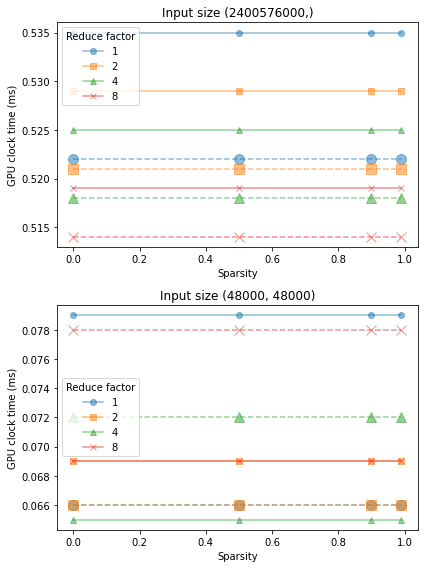

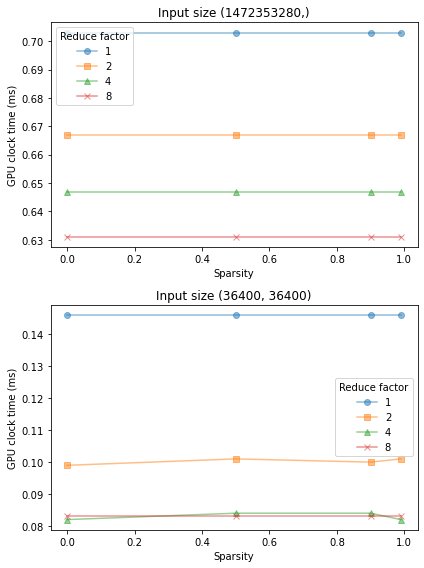

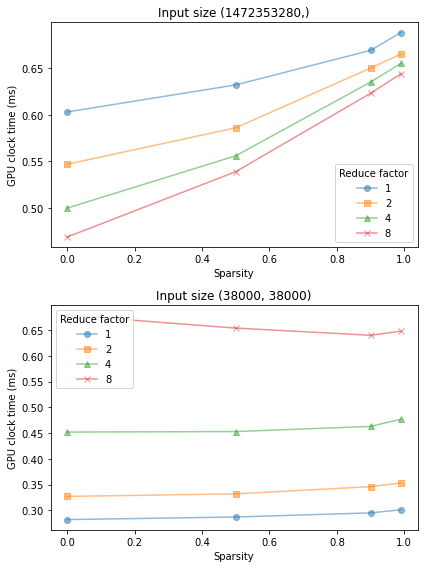

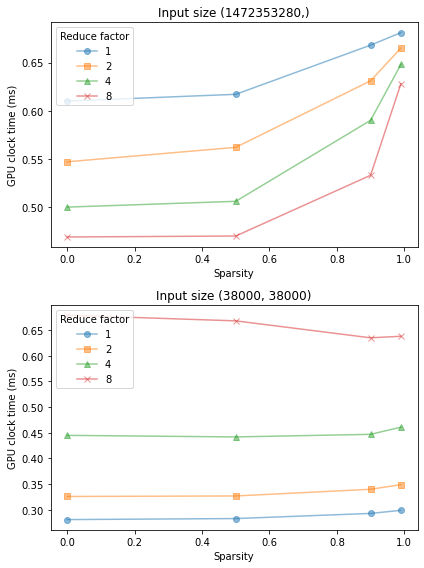

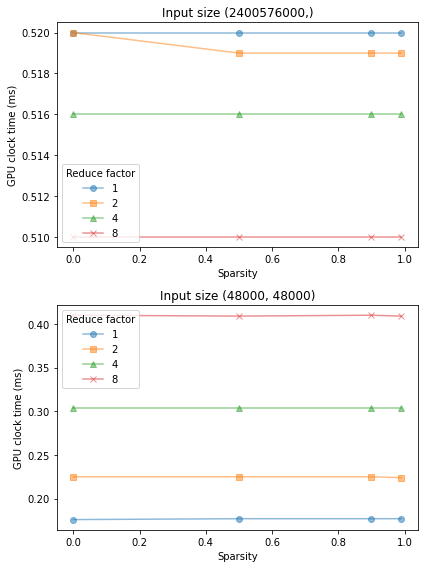

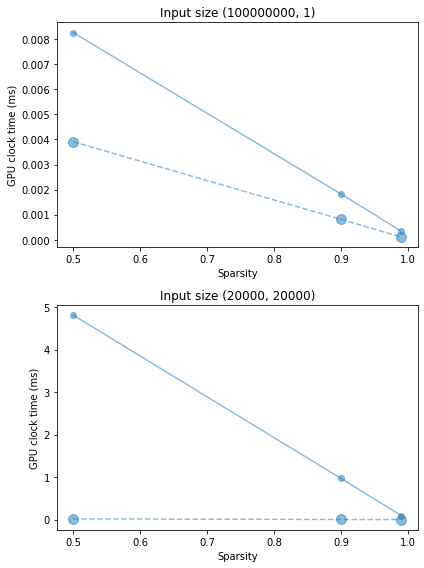

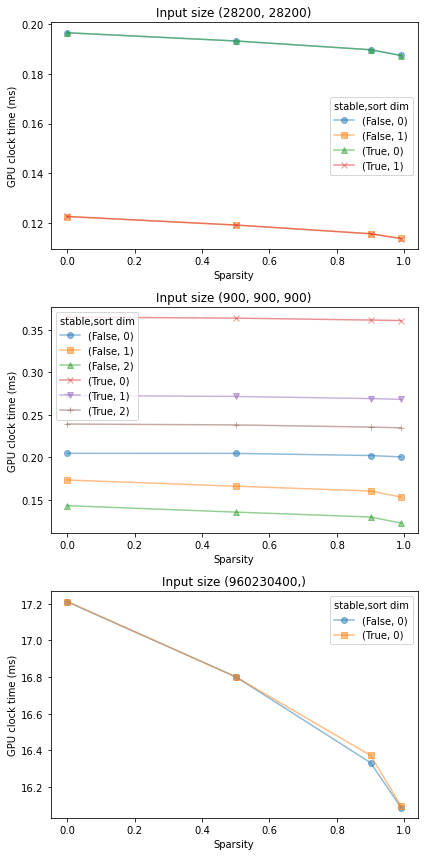

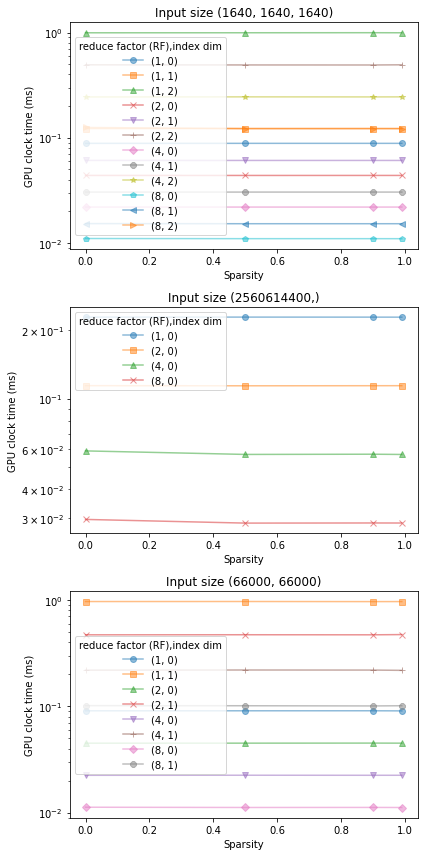

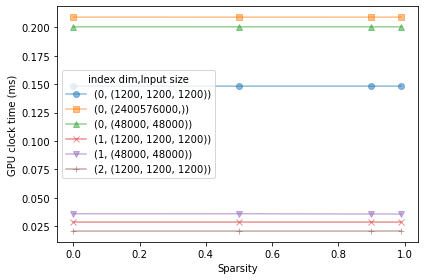

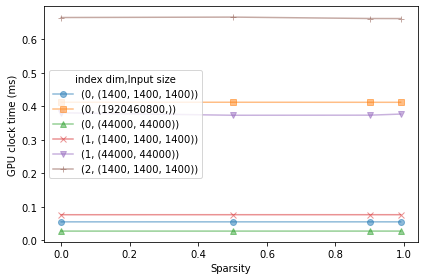

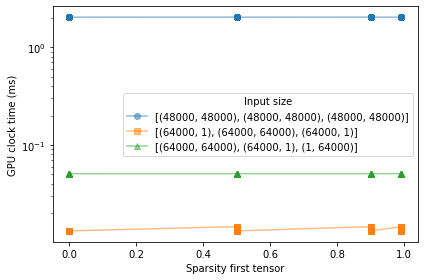

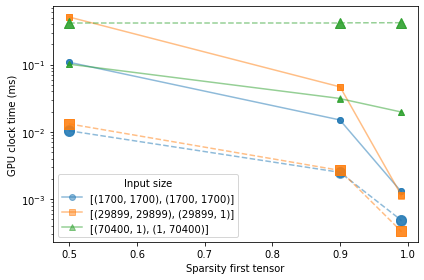

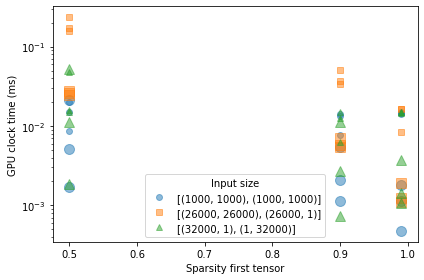

In [266]:
plot_all()

In [ ]:
for op_name in all_ops:
    op_name_ttt = "\\texttt{%s}" % op_name.replace("_", "\_")
    
    print("""\\begin{figure}[t]
    \centering
    \includegraphics[type=pdf,ext=.pdf,read=.pdf,scale = .5]{figs/%s}
    \caption{
    %s
    \label{fig:%s}}
    \end{figure}
    """ % (op_name, op_name_ttt, op_name))


In [49]:
op2df, all_ops = reload_data()
all_ops

['scatter_mean',
 'native_sort',
 'native_index_select',
 'native_addmm',
 'native_gather',
 'scatter_min',
 'sparse_spmm',
 'scatter_add',
 'scatter_multiply',
 'scatter_max',
 'sparse_spspmm',
 'native_index_add_',
 'sparse_transpose']

In [202]:
!ls -l ./data/

total 76
-rw-r--r-- 1 rhosseini datascience 16633 Apr 13 23:33 native_addmm.csv
-rw-r--r-- 1 rhosseini datascience  1293 Apr 13 23:33 native_gather.csv
-rw-r--r-- 1 rhosseini datascience  1287 Apr 13 23:33 native_index_add_.csv
-rw-r--r-- 1 rhosseini datascience  5285 Apr 13 23:33 native_index_select.csv
-rw-r--r-- 1 rhosseini datascience  2729 Apr 13 23:33 native_sort.csv
drwxr-sr-x 2 rhosseini datascience  4096 Apr 11 19:51 old_data_do_not_use
-rw-r--r-- 1 rhosseini datascience  1498 Apr 13 23:33 scatter_add.csv
-rw-r--r-- 1 rhosseini datascience  1304 Apr 13 23:33 scatter_max.csv
-rw-r--r-- 1 rhosseini datascience  1240 Apr 13 23:33 scatter_mean.csv
-rw-r--r-- 1 rhosseini datascience  1238 Apr 13 23:33 scatter_min.csv
-rw-r--r-- 1 rhosseini datascience  1231 Apr 13 23:33 scatter_multiply.csv
-rw-r--r-- 1 rhosseini datascience  2475 Apr 13 23:33 sparse_spmm.csv
-rw-r--r-- 1 rhosseini datascience  2493 Apr 13 23:33 sparse_spspmm.csv
-rw-r--r-- 1 rhosseini datascience   522 Apr 13 23:3

In [40]:
for op,df in op2df.items():
    print(op, df.columns.to_list())

scatter_mean ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
native_sort ['Input dims, sort dim, stable', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
native_index_select ['Input dims, index dim, reduce factor (RF)', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
native_addmm ['Input dims', 'Input size (>95% mem util)*', 'Sparsities (input, matA, matB)', 'GPU clock time']
native_gather ['Input dims, index dim', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_min ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
sparse_spmm ['Input dims', 'Input size (>95% mem util)*', 'Sparsities (input, matA, matB)', 'GPU clock time']
scatter_add ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_multiply ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_max ['Reduce factor, shape', 'Input siz

In [201]:
op2df["sparse_transpose"]

,Input Shape,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,Square,"(20000, 20000)",0.50,4.809033749625087 (0.01572903897613287)
1,LS,"(100000000, 1)",0.50,0.00826227143406868 (0.003907048907130957)
2,Square,"(20000, 20000)",0.90,0.9677704963833094 (0.003117789663374424)
3,LS,"(100000000, 1)",0.90,0.0018250740692019461 (0.0008138376474380493)
4,Square,"(20000, 20000)",0.99,0.09618449956178665 (0.0003600620906800032)
5,LS,"(100000000, 1)",0.99,0.00034510129317641256 (0.00011050148308277131)


# plots

## `scatter_`, `spline_`, `sparse_transpose`

'scatter_mean'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(1472353280,)",0.0,0.703
1,1 square,"(36400, 36400)",0.0,0.146
2,1 LS,"(1472353280,)",0.5,0.703


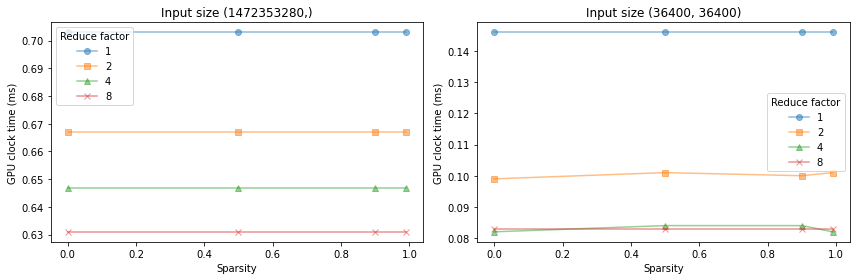

'scatter_min'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(1472353280,)",0.0,0.603
1,1 square,"(38000, 38000)",0.0,0.282
2,1 LS,"(1472353280,)",0.5,0.632


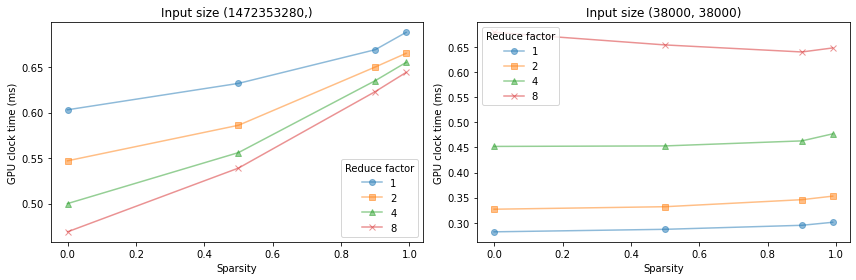

'scatter_add'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(2400576000,)",0.0,0.535 (0.522)
1,1 square,"(48000, 48000)",0.0,0.079 (0.066)
2,1 LS,"(2400576000,)",0.5,0.535 (0.522)


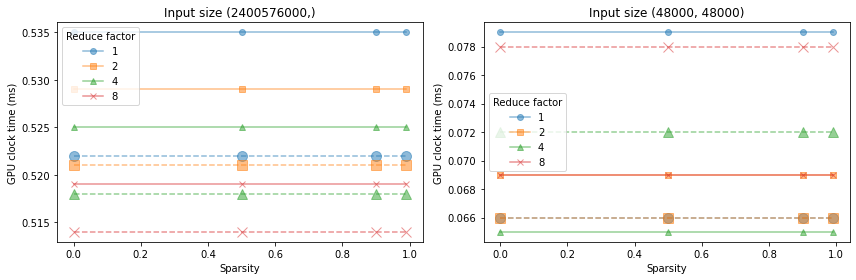

'scatter_multiply'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(2400576000,)",0.0,0.520
1,1 square,"(48000, 48000)",0.0,0.176
2,1 LS,"(2400576000,)",0.5,0.520


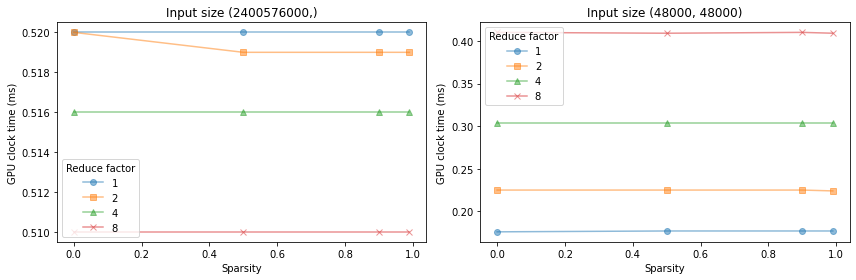

'scatter_max'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time,IQR
0,8 square,"(38000, 38000)",0.99,0.638,0
1,8 LS,"(1472353280,)",0.99,0.628,0
2,8 square,"(38000, 38000)",0.90,0.635,0


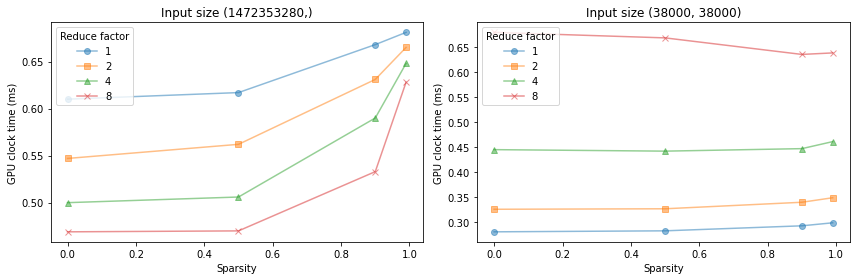

'sparse_transpose'

,Input Shape,Input size (>95% mem util)*,Sparsity,GPU clock time
0,Square,"(20000, 20000)",0.5,4.809033749625087 (0.01572903897613287)
1,LS,"(100000000, 1)",0.5,0.00826227143406868 (0.003907048907130957)
2,Square,"(20000, 20000)",0.9,0.9677704963833094 (0.003117789663374424)


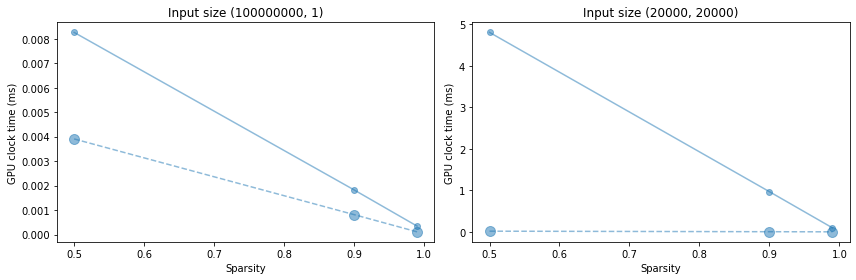

In [238]:
op2df, all_ops = reload_data()

for op_name in all_ops:
    if "scatter_" in op_name or "spline_" in op_name or "sparse_transpose" in op_name:
        display(op_name, op2df[op_name][:3])
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values=" ")
        ax = plot_operation(df, 
                            plots_cols=["Input size (>95% mem util)*"], 
                            curves_cols=None if "sparse_transpose" in op_name else ["Reduce factor"], 
                            op_name=op_name, show_title=False)
        plt.tight_layout()
        plt.show()

In [228]:
op2df["sparse_transpose"]

,Input Shape,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,Square,"(20000, 20000)",0.50,4.809033749625087 (0.01572903897613287)
1,LS,"(100000000, 1)",0.50,0.00826227143406868 (0.003907048907130957)
2,Square,"(20000, 20000)",0.90,0.9677704963833094 (0.003117789663374424)
3,LS,"(100000000, 1)",0.90,0.0018250740692019461 (0.0008138376474380493)
4,Square,"(20000, 20000)",0.99,0.09618449956178665 (0.0003600620906800032)
5,LS,"(100000000, 1)",0.99,0.00034510129317641256 (0.00011050148308277131)


##### swap columns used for plots and curves

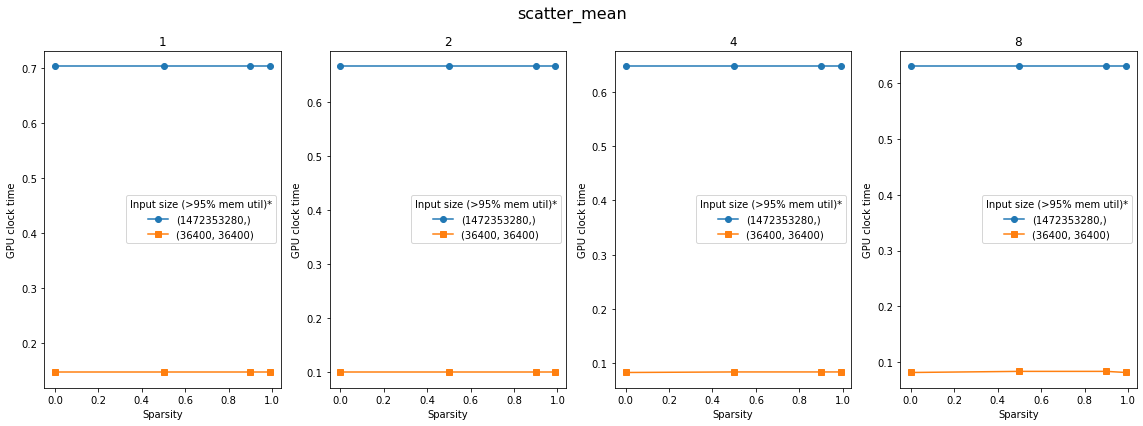

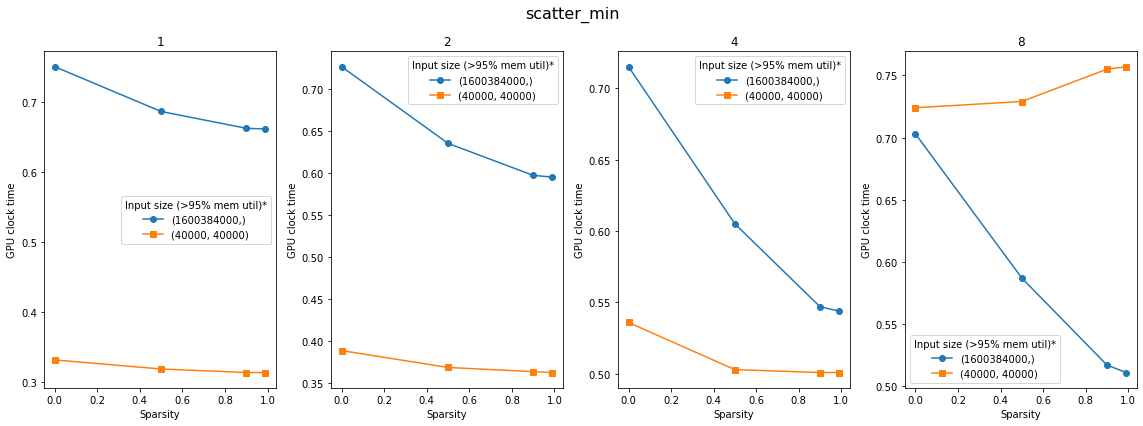

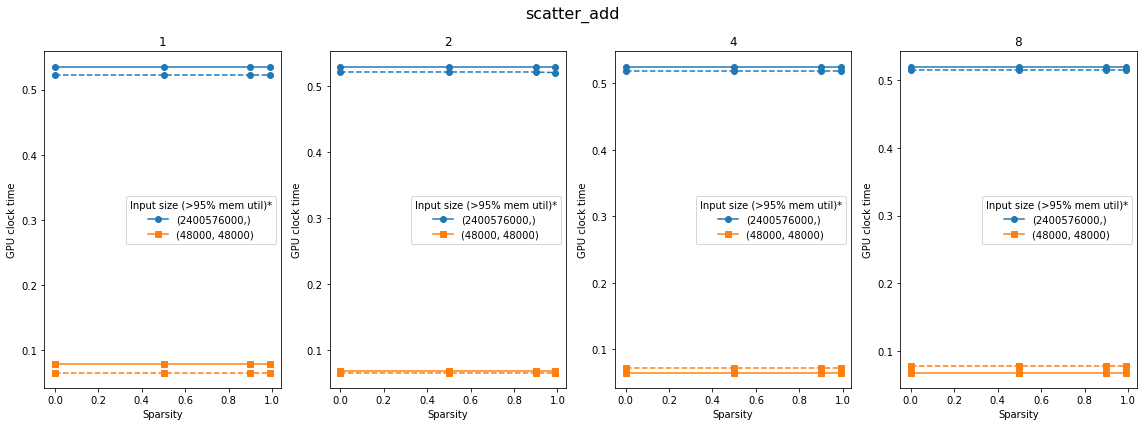

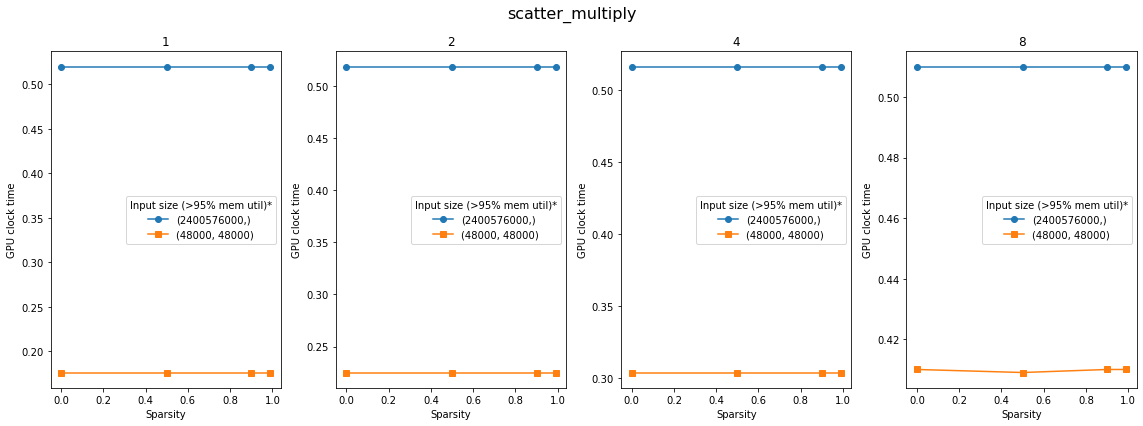

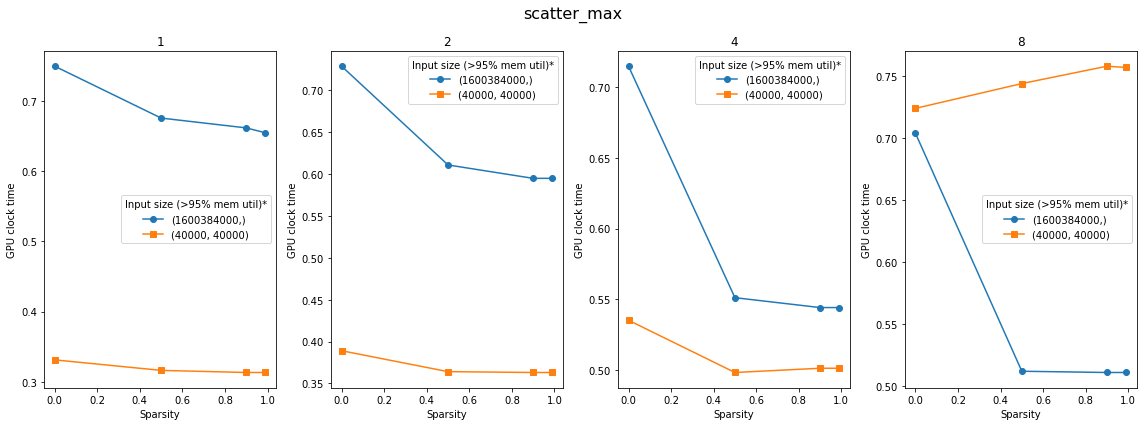

In [203]:
for op_name in all_ops:
    if "scatter_" in op_name:
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values=" ")
        plot_operation(df, plots_cols=["Reduce factor"], curves_cols=["Input size (>95% mem util)*"], op_name=op_name)

## `native_`

native_sort


,"Input dims, sort dim, stable",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0; True,"(960230400,)",0.0,17.212551
1,1; 0; False,"(960230400,)",0.0,17.210920
2,2; 0; True,"(28200, 28200)",0.0,0.196620


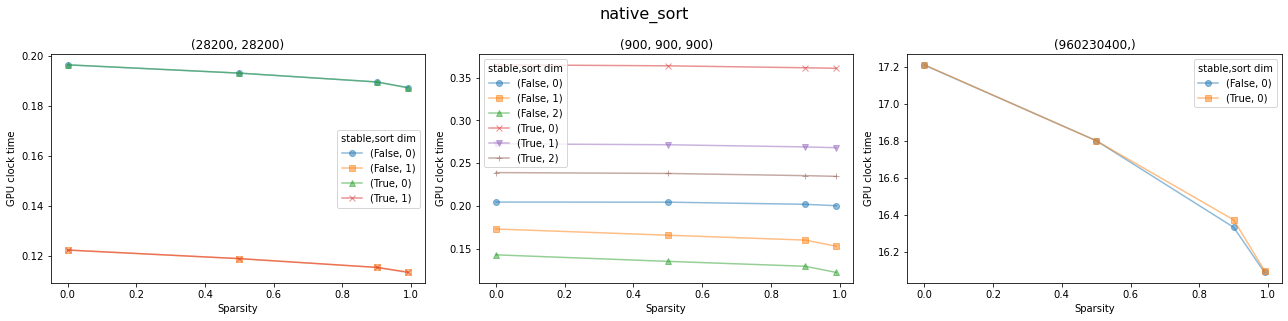

native_index_select


,"Input dims, index dim, reduce factor (RF)",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0; 1,"(2560614400,)",0.0,0.227669
1,1; 0; 2,"(2560614400,)",0.0,0.113962
2,1; 0; 4,"(2560614400,)",0.0,0.058981


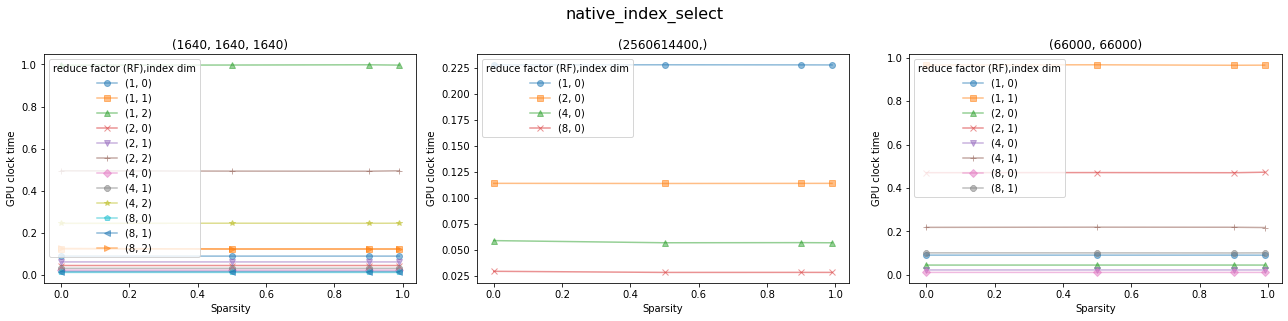

native_gather


,"Input dims, index dim",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0,"(2400576000,)",0.0,0.208929
1,2; 0,"(48000, 48000)",0.0,0.200370
2,2; 1,"(48000, 48000)",0.0,0.036084


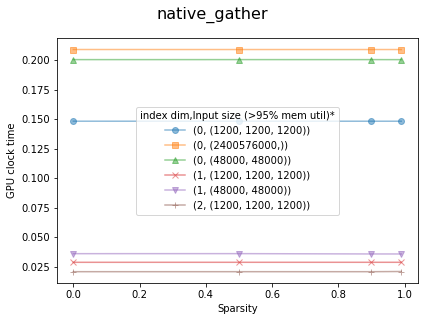

native_index_add_


,"Input dims, index dim",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0,"(1920460800,)",0.0,0.412412
1,2; 0,"(44000, 44000)",0.0,0.027599
2,2; 1,"(44000, 44000)",0.0,0.380915


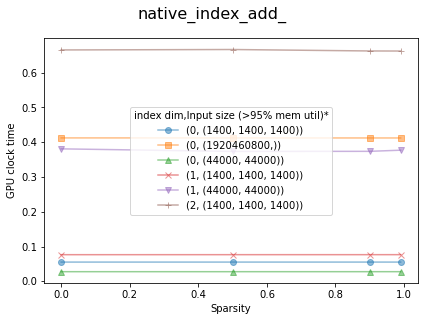

In [51]:
op2df, all_ops = reload_data()

for op_name in all_ops:
    if "native_" in op_name and "native_addmm" not in op_name:
        print(op_name)
        display(op2df[op_name][:3])
        old_cols = set(op2df[op_name].columns)
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values="; ")
        curves_cols = list(set(df.columns) - old_cols - {"GPU clock time PT", "Input dims"})
        ax = plot_operation(df, 
                       plots_cols=None if op_name in ["native_index_add_", "native_gather"] else ["Input size (>95% mem util)*"], 
                       curves_cols=curves_cols + ["Input size (>95% mem util)*"] if op_name in ["native_index_add_", "native_gather"] else curves_cols, 
                       op_name=op_name)
        
        plt.tight_layout()
        plt.show()

## `native_addmm`, `sparse_spmm`, `sparse_spspmm`

native_addmm


,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0 ; 0 ; 0,2.021733
1,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0 ; 0 ; 0,0.050985
2,3,"[(64000, 1), (64000, 64000), (64000, 1)]",0 ; 0 ; 0,0.013211


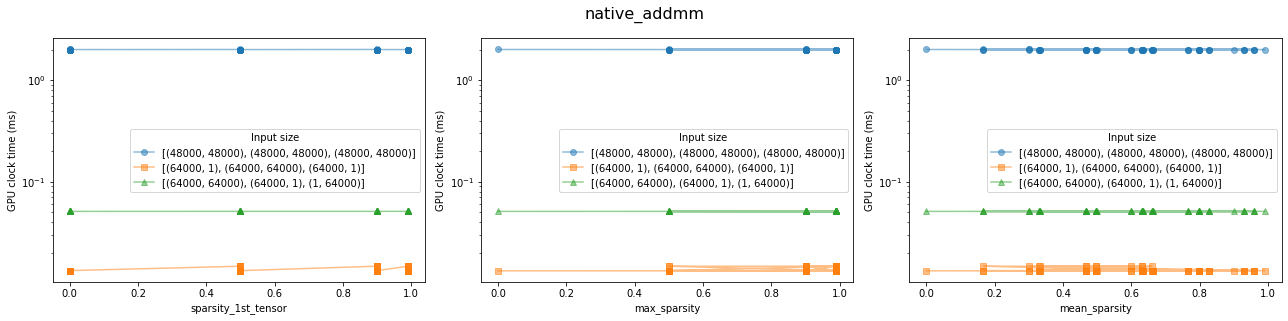

sparse_spmm


,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,2,"[(1700, 1700), (1700, 1700)]",0.5 ; 0.5,0.10778759978711605 (0.010532762855291367)
1,2,"[(70400, 1), (1, 70400)]",0.5 ; 0.5,0.10241412092000246 (0.41660175286233425)
2,2,"[(29899, 29899), (29899, 1)]",0.5 ; 0.5,0.5089759286493063 (0.013162935525178908)


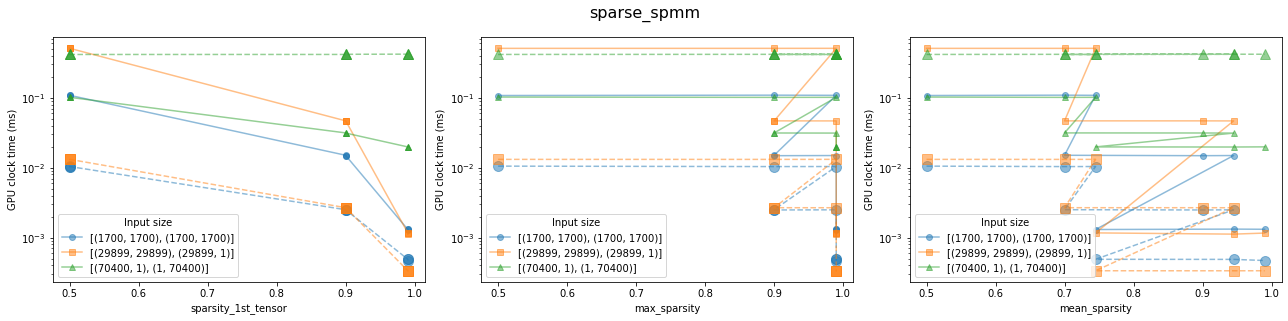

sparse_spspmm


,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,2,"[(1000, 1000), (1000, 1000)]",0.5 ; 0.5,0.019902581349015236 (0.021485098265111448)
1,2,"[(32000, 1), (1, 32000)]",0.5 ; 0.5,0.04772329814732075 (0.051753748394548896)
2,2,"[(26000, 26000), (26000, 1)]",0.5 ; 0.5,0.23682555183768272 (0.027650673501193525)


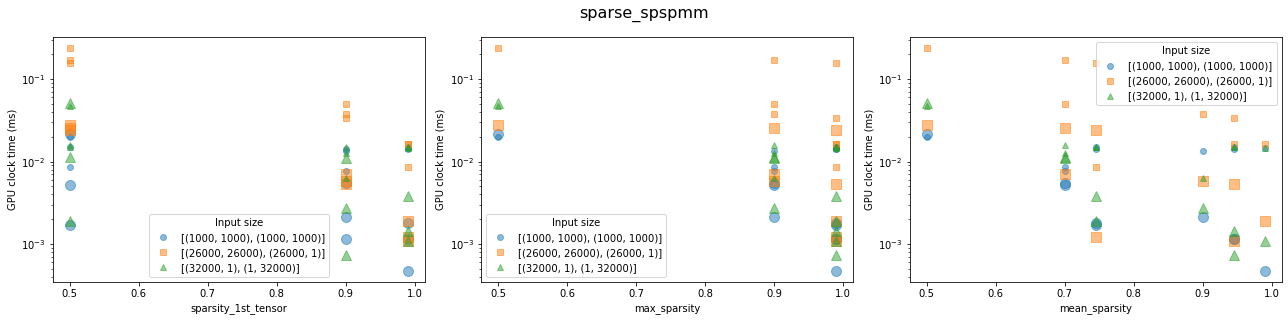

In [241]:
op2df, all_ops = reload_data()

op_list = ["native_addmm", "sparse_spmm", "sparse_spspmm"]

for op_name in op_list:
    print(op_name)
    display(op2df[op_name][:3])

    old_cols = set(op2df[op_name].columns)
    df = split_column(op2df[op_name], i=2, col=None, delim_colname=", " if "native" in op_name else "(", delim_values=" ; ")
    new_cols = list(set(df.columns) - old_cols - {'GPU clock time PT'})
    sparsity_1st_tensor = df.columns[df.columns.str.contains("Sparsities")].to_list()[0]
    df[new_cols] = df[new_cols].astype(float)
    df["max_sparsity"] = df[new_cols].max(axis=1)
    df["mean_sparsity"] = df[new_cols].mean(axis=1)
    df["min_sparsity"] = df[new_cols].min(axis=1)
    df["sparsity_1st_tensor"] = df[sparsity_1st_tensor]

    all_plots = ["sparsity_1st_tensor", "max_sparsity", "mean_sparsity"]#, "min_sparsity"]
    ncols = len(all_plots)
    nrows = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4.5 * nrows)) #, sharey=True

    for ii,idx in enumerate(all_plots):
        markers, _  = get_markers_colors()
        df = df.set_index(idx)
        curves_cols = ["Input size (>95% mem util)*"]

        plt.subplot(1, ncols, ii + 1)
        ax = plot_operation(df, 
                       plots_cols=None, 
                       curves_cols=curves_cols, 
                       op_name=op_name, axes=axes[ii])

        ax[0].set_yscale("log")
#         ax[0].set_xscale("log")
    plt.suptitle(op_name, fontsize=16)
    plt.tight_layout()
    plt.show()

#### alt. plots

,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0 ; 0 ; 0,2.021733
1,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0 ; 0 ; 0,0.050985
2,3,"[(64000, 1), (64000, 64000), (64000, 1)]",0 ; 0 ; 0,0.013211


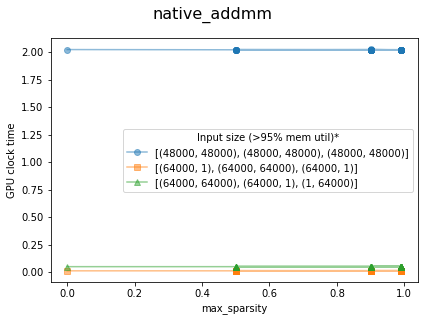

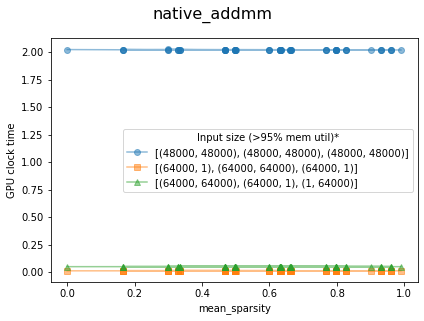

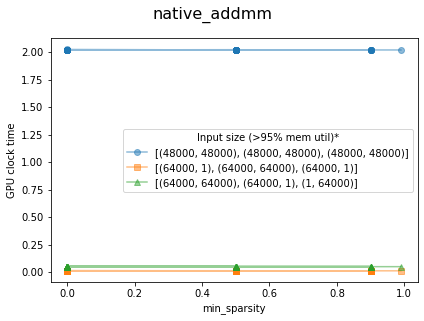

In [105]:
op_name = "native_addmm"
op2df, all_ops = reload_data()

display(op2df[op_name][:3])

old_cols = set(op2df[op_name].columns)
df = split_column(op2df[op_name], i=2, col=None, delim_colname=", ", delim_values=" ; ")
new_cols = list(set(df.columns) - old_cols)
df[new_cols] = df[new_cols].astype(float)
df["max_sparsity"] = df[new_cols].max(axis=1)
df["mean_sparsity"] = df[new_cols].mean(axis=1)
df["min_sparsity"] = df[new_cols].min(axis=1)

for idx in ["max_sparsity", "mean_sparsity", "min_sparsity"]:
    markers, _  = get_markers_colors()
    df = df.set_index(idx)
    y_col = "GPU clock time"
    curves_cols = ["Input size (>95% mem util)*"]
    
    ax = plot_operation(df, 
                   plots_cols=None, 
                   curves_cols=curves_cols, 
                   op_name=op_name)

    plt.tight_layout()
    plt.show()

,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0 ; 0 ; 0,2.021733
1,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0 ; 0 ; 0,0.050985
2,3,"[(64000, 1), (64000, 64000), (64000, 1)]",0 ; 0 ; 0,0.013211


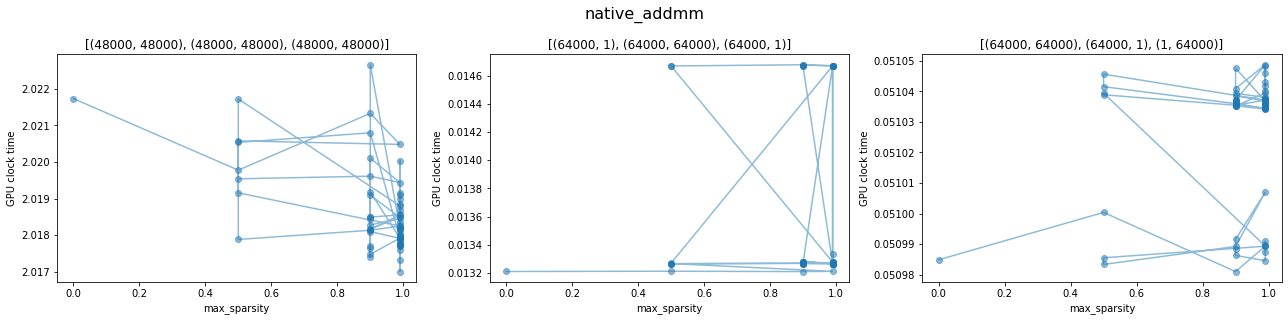

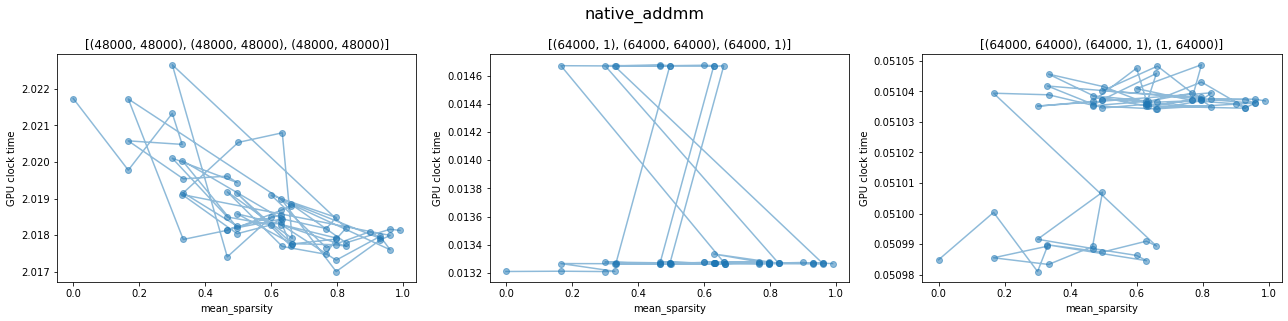

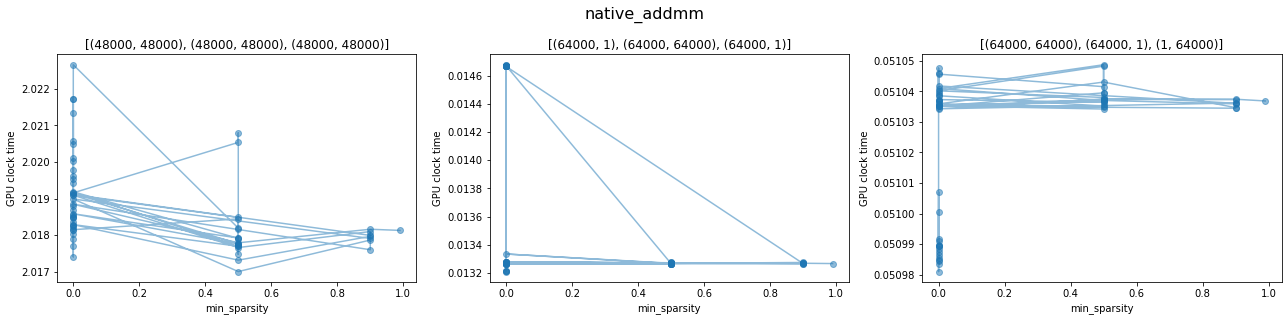

In [125]:
op_name = "native_addmm"
op2df, all_ops = reload_data()

display(op2df[op_name][:3])

old_cols = set(op2df[op_name].columns)
df = split_column(op2df[op_name], i=2, col=None, delim_colname=", ", delim_values=" ; ")
new_cols = list(set(df.columns) - old_cols)
df[new_cols] = df[new_cols].astype(float)
df["max_sparsity"] = df[new_cols].max(axis=1)
df["mean_sparsity"] = df[new_cols].mean(axis=1)
df["min_sparsity"] = df[new_cols].min(axis=1)

for idx in ["max_sparsity", "mean_sparsity", "min_sparsity"]:
    markers, _  = get_markers_colors()
    df = df.set_index(idx)
    y_col = "GPU clock time"
    curves_cols = ["Input size (>95% mem util)*"]
    
    ax = plot_operation(df, 
                   plots_cols=curves_cols, 
                   curves_cols=None, 
                   op_name=op_name)
    
    plt.tight_layout()
    plt.show()